# Phase 1 refined data is sampled, discretized and pre-processed in 'static voltage-dynamic voltage-static voltage' time series sequences


In [1]:
%reload_ext autoreload
# for auto reloading modules without kernel restart
# If this does not work to import custom modules, then restart kernel

In [2]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_26580/696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.1
numpy version: 1.21.2


In [4]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive
# constants for plotting
x_label_elapsedtime = 0
x_label_datetime = 1

In [6]:
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'df_phase1_refined.pkl')

df = pd.read_pickle(src_path)

print(df['timestamp'].is_monotonic_increasing)

True


In [7]:
# print(df.head(5))
print(df['timestamp'].duplicated().sum())   # print num of duplicates if any

0


In [8]:
tu_time_divided_ts = data_preprocess.get_ts_records_by_timegap(df, 'timestamp', 1) # rets tuple of dfs
print(len(tu_time_divided_ts))   # output: 5 different time series of 1 Hz sampling rate

5


In [9]:
# test: bug fix
print(df['contactor_state'].dtype)
print(max(df['contactor_state']))
print(min(df['contactor_state']))
print(df['contactor_state'].isnull().sum())
print(df['current'].isnull().sum())
print(df['V1'].isnull().sum())

float64
3.0
0.0
0
0
0


In [9]:
# get sequence that have both contactor on and off
li_ts_segments = data_preprocess.get_continuous_ts_segments_list(tu_time_divided_ts)
li_ts_segments = [data_preprocess.add_elapsed_sec(each_df, 'timestamp') for each_df in li_ts_segments] # Add elapsed time for plotting and other reasons

In [10]:
# Save list as pkl checkpoint
import pickle
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'li_phase1_ts_segments.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(li_ts_segments, f)

In [13]:
# print(len(li_ts_segments))
# print(li_ts_segments[0])

## Plot and compare different battery voltages over time (necessary for report)
### Reasoning for not taking categorical battery cell, or treating cells uniformly

<IPython.core.display.Javascript object>


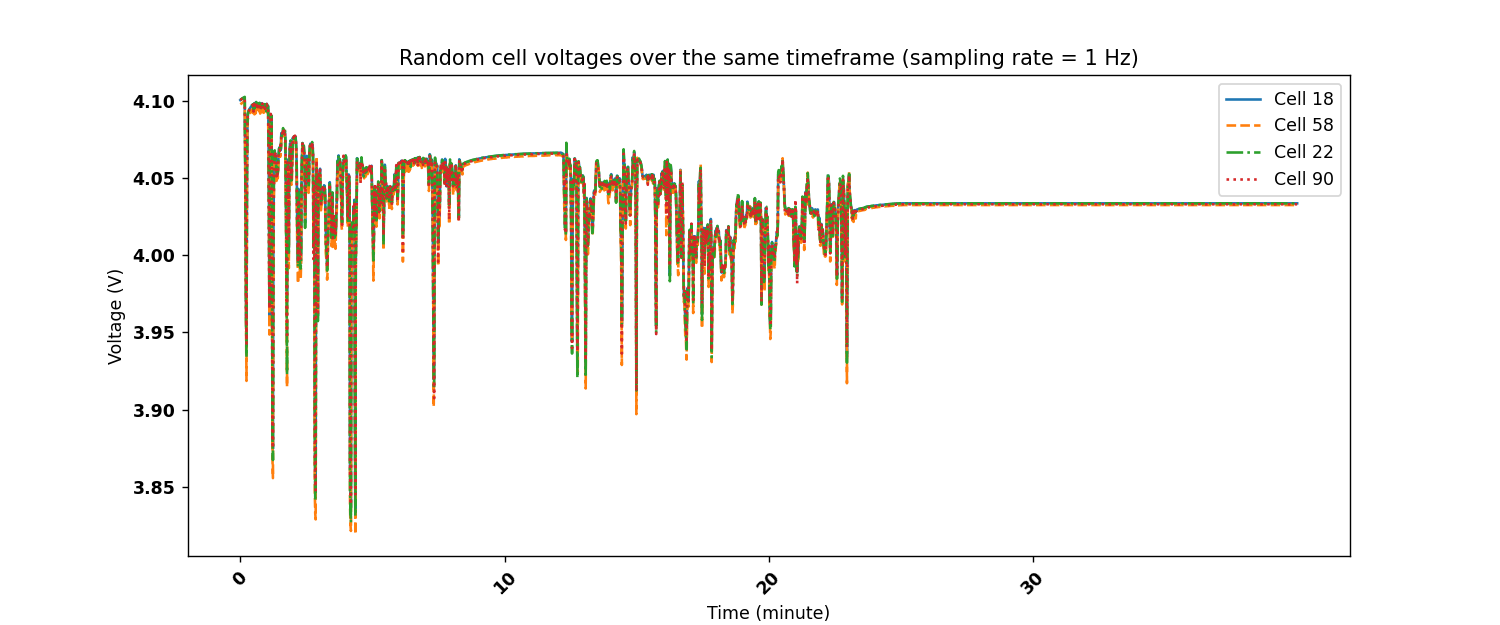

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [41]:
%matplotlib notebook

random.seed(100)           # seed for regenerating, any number for seed
li_random_cells = random.sample(range(constants.NUM_CELLS), 4)    # randomly pick 4 battery cells
# which_continuous_ts = random.randint(0, len(li_ts_segments)-1)
df_temp = li_ts_segments[1].head(2400).copy()   # Take a small part of the data, each list element is a df of 1 Hz time series

fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'batteries_over_time.eps')

custom_plot.plot_multi_line(("Random cell voltages over the same timeframe (sampling rate = 1 Hz)", plot_path, "Voltage (V)"), (df_temp['elapsed_sec'], custom_plot.ELAPSED_TIME), (df_temp['V' + str(li_random_cells[0])], "Cell " + str(li_random_cells[0])), (df_temp['V' + str(li_random_cells[1])], "Cell " + str(li_random_cells[1])), (df_temp['V' + str(li_random_cells[2])], "Cell " + str(li_random_cells[2])), (df_temp['V' + str(li_random_cells[3])], "Cell " + str(li_random_cells[3])))

In [11]:
li_ts_segments[0]['timestamp'].is_monotonic_increasing

True

In [12]:
# insert dfs into a list
li_full_cycle = []           # each element is a df containing a ful cycle in sequence: static + dynamic + static
for i in range(len(li_ts_segments)):
    df_temp = li_ts_segments[i].copy()
    li_full_cycle += data_preprocess.get_full_cycles_list(df_temp, 'contactor_state', 'timestamp')

print(len(li_full_cycle))
print(type(li_full_cycle[0]))   # each element is a dataframe

36
<class 'pandas.core.frame.DataFrame'>


**Create list of useful battery cell data (filter out unnecessary parts):**
1. get static-dynamic-static timed sequences for voltage and time thresolds
2. $CellData$ is a list, each element of it is a data frames/time series, <br>
where each df is a valid static-dynamic-static cycle for the corresponding voltage
3. $CellData_{i} = [ts_{1}, ts_{2}, ...., ts_{n}]$, where ts = Time Series data frame
4. $ValidCycles = [CellData_{1}, CellData_{2}, ..., CellData_{n}]$      # for the car, total cells n= 96

In [13]:
li_cells_valid_cycles = []
for i in range(1, constants.NUM_CELLS + 1):
    li_cells_valid_cycles.append(data_preprocess.get_valid_cycles_list(li_full_cycle, 'V'+str(i), 'timestamp'))
# V1_valid_cycle = data_preprocess.get_valid_cycles_list(li_full_cycle, 'V1', 'timestamp')
# print(len(V1_valid_cycle))

In [14]:
# Check how many valid data points
sum_ts = 0
print('total cells: ', len(li_cells_valid_cycles))
for i in range(constants.NUM_CELLS):
    print('cell ', i+1, ' has ', len(li_cells_valid_cycles[i]), ' cycles')
    sum_ts += len(li_cells_valid_cycles[i])
print('Total number of cycles: ', sum_ts)

total cells:  96
cell  1  has  28  cycles
cell  2  has  28  cycles
cell  3  has  28  cycles
cell  4  has  28  cycles
cell  5  has  28  cycles
cell  6  has  34  cycles
cell  7  has  34  cycles
cell  8  has  34  cycles
cell  9  has  34  cycles
cell  10  has  33  cycles
cell  11  has  34  cycles
cell  12  has  34  cycles
cell  13  has  34  cycles
cell  14  has  34  cycles
cell  15  has  34  cycles
cell  16  has  34  cycles
cell  17  has  34  cycles
cell  18  has  34  cycles
cell  19  has  34  cycles
cell  20  has  32  cycles
cell  21  has  32  cycles
cell  22  has  33  cycles
cell  23  has  34  cycles
cell  24  has  34  cycles
cell  25  has  34  cycles
cell  26  has  32  cycles
cell  27  has  32  cycles
cell  28  has  34  cycles
cell  29  has  32  cycles
cell  30  has  32  cycles
cell  31  has  32  cycles
cell  32  has  34  cycles
cell  33  has  34  cycles
cell  34  has  32  cycles
cell  35  has  33  cycles
cell  36  has  34  cycles
cell  37  has  34  cycles
cell  38  has  34  cycles
cell

In [15]:
print(len(li_cells_valid_cycles[0]))
print(type(li_cells_valid_cycles[0]))


28
<class 'list'>


In [21]:
# %matplotlib notebook
# # Randomly plot some ts from battery cells
# import random

# # Take randomly 10 dfs from list and plot them
# random.seed(0)           # seed for regenerating, any number for seed
# li_random_cells = random.sample(range(constants.NUM_CELLS), 4)    # randomly pick 4 battery cells

# for i in range(len(li_random_cells)):
#     outer_list_id = li_random_cells[i]
#     li_cellx_cycles = li_cells_valid_cycles[outer_list_id]
#     random.seed(li_random_cells[i])

#     inner_list_id = random.randrange(len(li_cellx_cycles))    # a random number between 0 and (len(li_cycles) -1 ) inclusive
#     print('inner index', inner_list_id)
#     df_temp = li_cellx_cycles[inner_list_id].copy()
#     column_name = 'V'+str(outer_list_id)
#     custom_plot.plot_dual_axis((df_temp['timestamp'], "Time"), (df_temp['current'], "current"), (df_temp[column_name], column_name))

# print(li_random_cells)


### Save filtered time series samples with all columns

In [ ]:
# Save list as pkl checkpoint
import pickle
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'li_phase1_cells_valid_cycles.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(li_cells_valid_cycles, f)

### Load time series samples with all columns

In [7]:
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'li_phase1_cells_valid_cycles.pkl')

with open(src_path, 'rb') as f:
    li_cells_valid_cycles = pickle.load(f)

**Create list of OCV-dynamic-OCV cycles by cells, filter out null, or constant values and restructure data:**
1. Each OCV-dynamic-OCV cycle is called a $ProcessedCycle (PC)$. Each PC is a time series dataframe containing voltage, current, temperature, contactor status etc.
2. $PCList$ is a list, each element of it is a $PC$
3. $PCList_{cell_i} = [PC_{1}, PC_{2}, ...., PC_{n}]$, $[k =$ number of valid OCV-dynamic-OCV cycle for $cell_i$]
4. $CellCycles = [(cell_1, PCList_{cell_1}), (cell_2, PCList_{cell_2}), ..., (cell_n, PCList_{cell_n})]$      # for the car, total cells n= 96

In [50]:
# Filter cycles that have constant voltage or current throughout the entire time line
# Remove unrelated voltages from li_cells_valid_cycles

li_cell_cycles = []          # each element contains (voltage_cellno, ValidCycles) where ValidCycles=[valid_cycles] for that cell
li_cycle_df = []
for i in range(len(li_cells_valid_cycles)):
    cell_id = i + 1
    
    if(1 <= cell_id <= 12):
        col_temp = 'Temp_mean_module1'
    elif(13 <= cell_id <= 24):
        col_temp = 'Temp_mean_module2'
    elif(25 <= cell_id <= 36):
        col_temp = 'Temp_mean_module3'
    elif(37 <= cell_id <= 48):
        col_temp = 'Temp_mean_module4'
    elif(49 <= cell_id <= 60):
        col_temp = 'Temp_mean_module5'
    elif(61 <= cell_id <= 72):
        col_temp = 'Temp_mean_module6'
    elif(73 <= cell_id <= 84):
        col_temp = 'Temp_mean_module7'
    elif(85 <= cell_id <= 96):
        col_temp = 'Temp_mean_module8'

    li_cellx_cycles = li_cells_valid_cycles[i]
    for df_x in li_cellx_cycles:
        df_temp = df_x.copy()
        # print(df_temp)
        if(data_preprocess.is_unique(df_temp['V'+str(cell_id)]) or data_preprocess.is_unique(df_temp['current'])):
            # all voltages are same, or all current values are same, do not append
            pass
        else:
            # keep minimum columns and append to cycle list
            voltage_cellno = 'V' + str(cell_id)
            df_temp = df_temp[['timestamp', 'current', 'min_SOC', 'cur_integral_module1', 'contactor_state', 'contactor_off_time', 
                 voltage_cellno, col_temp]]
            df_temp = data_preprocess.add_elapsed_sec(df_temp, 'timestamp')
            df_temp.rename(columns = {voltage_cellno:'V', col_temp:'Temp'}, inplace = True)
            # append tuple of (voltage_cellno, ValidCycles) as each element
            li_cycle_df.append(df_temp)
    
    # append to outer list
    li_cell_cycles.append((voltage_cellno, li_cycle_df))
    li_cycle_df = []      # initialize inner cycle list


### Save cell_cycles

In [51]:
# Save list as pkl checkpoint
import pickle
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'cell_cycles.pkl')

with open(src_path, 'wb') as f:
    pickle.dump(li_cell_cycles, f)

### Load cell cycles  (start from here every time)

In [8]:
import pickle
# load last saved df and convert time stamp and sort
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'cell_cycles.pkl')

with open(src_path, 'rb') as f:
    li_cell_cycles = pickle.load(f)

In [53]:
print(len(li_cell_cycles))
# print(li_cell_cycles[0])

96


[49, 53, 5, 33]


<IPython.core.display.Javascript object>


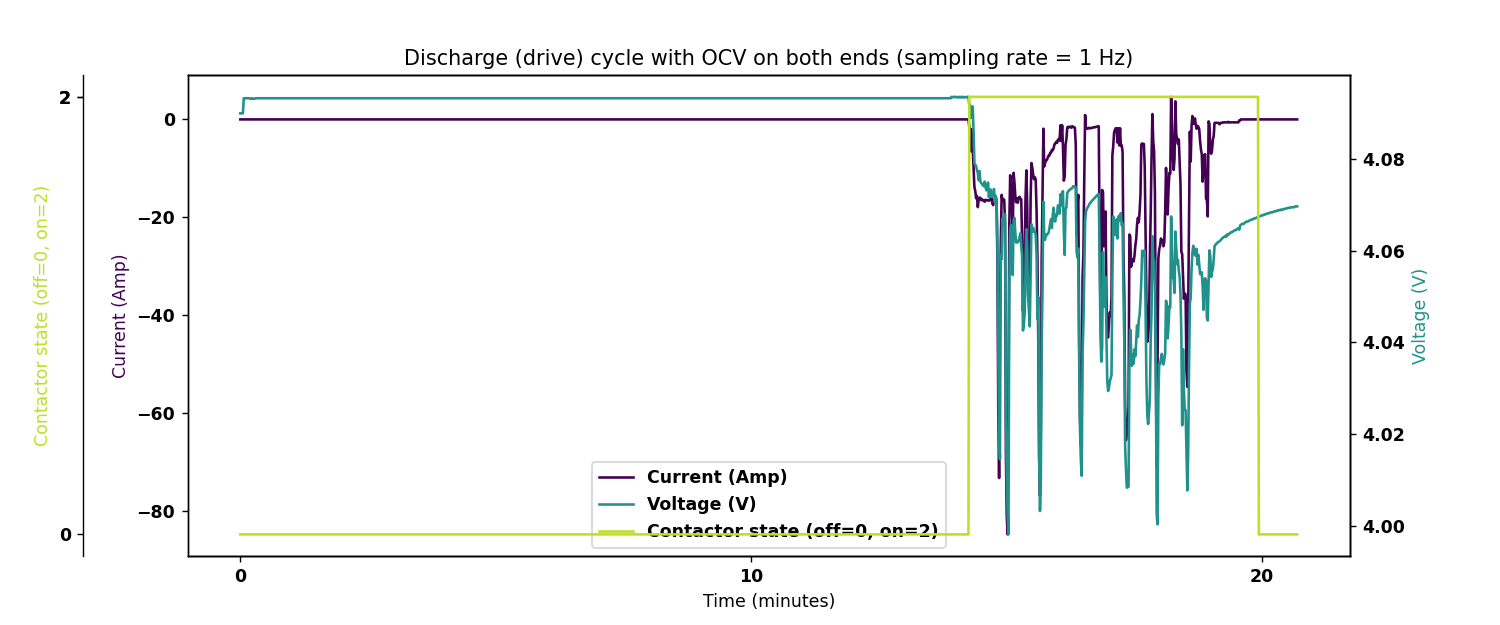

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [54]:
%matplotlib notebook
# Randomly plot some cycles for report, keep both charge + discharge and only discharge (drive cycle)
import random

# Take randomly 10 dfs from list and plot them
random.seed(0)           # seed for regenerating, any number for seed
li_random_cycles = random.sample(range(len(li_cell_cycles)), 4)    # randomly pick 4 battery cells
fig_path = os.path.join(cwd, 'figures')
plot_path = os.path.join(fig_path, 'cycle1.eps')

print(li_random_cycles)
voltage_cell, li_cycles = li_cell_cycles[li_random_cycles[1]]
id_rand_cycle = random.randint(0, len(li_cycles)-1)
df_temp = li_cycles[id_rand_cycle].copy()

custom_plot.multi_scale_plot(("Discharge (drive) cycle with OCV on both ends (sampling rate = 1 Hz)", plot_path), (df_temp['elapsed_sec'], constants.x_label_elapsedtime), (df_temp['current'], "Current (Amp)"), (df_temp['V'], "Voltage (V)"), (df_temp['contactor_state'], "Contactor state (off=0, on=2)"))


6


<IPython.core.display.Javascript object>


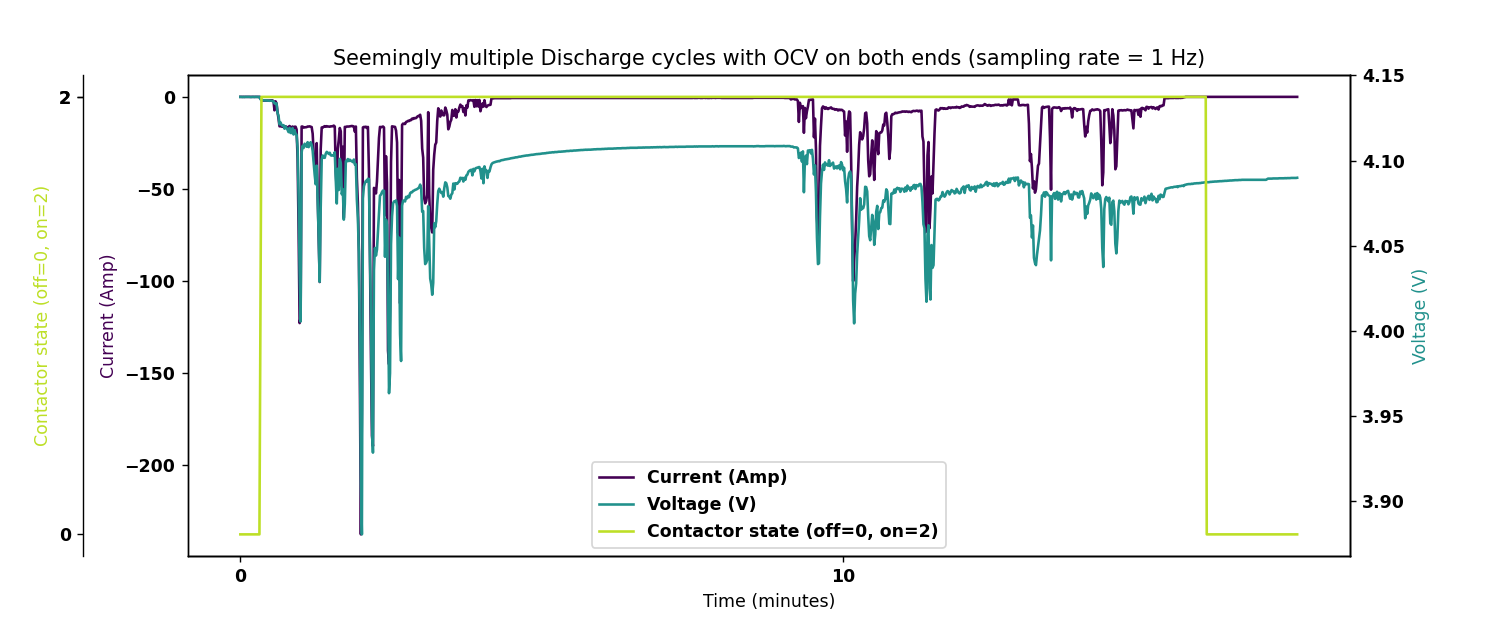

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [55]:
# Plot another
plot_path = os.path.join(fig_path, 'cycle2.eps')
random.seed(0)
voltage_cell, li_cycles = li_cell_cycles[li_random_cycles[3]]
id_rand_cycle = random.randint(0, len(li_cycles)-1)
print(len(li_cycles))
df_temp = li_cycles[id_rand_cycle].copy()

custom_plot.multi_scale_plot(("Seemingly multiple Discharge cycles with OCV on both ends (sampling rate = 1 Hz)", plot_path), (df_temp['elapsed_sec'], constants.x_label_elapsedtime), (df_temp['current'], "Current (Amp)"), (df_temp['V'], "Voltage (V)"), (df_temp['contactor_state'], "Contactor state (off=0, on=2)"))

<IPython.core.display.Javascript object>


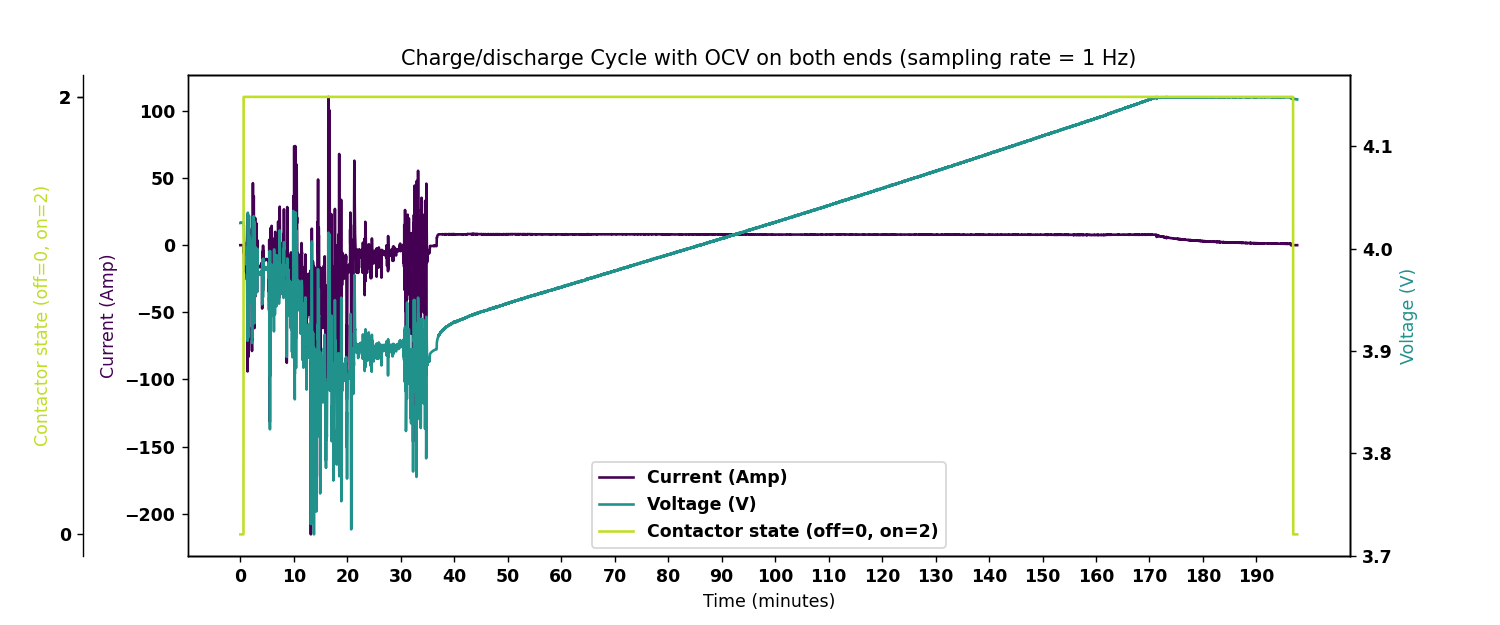

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [56]:
# Plot another
plot_path = os.path.join(fig_path, 'cycle3.eps')
random.seed(1)
voltage_cell, li_cycles = li_cell_cycles[li_random_cycles[2]]
df_temp = li_cycles[2].copy()

custom_plot.multi_scale_plot(("Charge/discharge Cycle with OCV on both ends (sampling rate = 1 Hz)", plot_path), (df_temp['elapsed_sec'], constants.x_label_elapsedtime), (df_temp['current'], "Current (Amp)"), (df_temp['V'], "Voltage (V)"), (df_temp['contactor_state'], "Contactor state (off=0, on=2)"))

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
import matplotlib.ticker as ticker
import matplotlib
import matplotlib.dates as mdates
import numpy as np

ELAPSED_TIME = 0
TIMESTAMP = 1

def plot_dual_axis(*axes):

    # assign argument values
    x_data, x_label = axes[0]
    y1_data, y1_label = axes[1]
    y2_data, y2_label = axes[2]


    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 10}

    matplotlib.rc('font', **font)
    fig = plt.figure(figsize =(10 ,7))
    plt.legend(bbox_to_anchor=(1.0, 1.0),prop={'size': 18,'weight' :'normal'})


    if (x_label == ELAPSED_TIME):
        scale_x = 60     # divide by 60 seconds
        li_ticks = np.arange(min(x_data), max(x_data)+1, 600)     # every 600 seconds = 10 minutes freq, assuming 1 Hz sampling rate
        li_labels = list(map(lambda x: int(x/scale_x), li_ticks))      # 60 sec = 1 minutes
        plt.xticks(li_ticks, li_labels, rotation=45)
        x_label = 'Time (minute)'
    elif (x_label == TIMESTAMP):
        x_label = 'Datetime'

    # Code for two different scale data in y axes, subplot is needed
    color_red = 'tab:red'
    fig, ax1 = plt.subplots()             # subplots() rets fig, array of axes
    ax1.set_ylabel(y1_label, color=color_red)
    ax1.plot(x_data, y1_data, color=color_red)
    ax1.tick_params(axis='y', labelcolor=color_red)  
    ax1.set_xticklabels(x_label, rotation=45)
#     ax1.set_xlabel(x_label)

    color_blue = 'tab:blue'
    ax2 = ax1.twinx()  # twinx() makes ax2 same as ax1, so no need to explicitly set_xlabel again
    ax2.set_ylabel(y2_label, color=color_blue)
    ax2.plot(x_data, y2_data, color=color_blue) # volt color red
    ax2.tick_params(axis='y', labelcolor=color_blue)

    plt.title("Values vs time") # set the whole plot name

    # plt.legend(['740.minsoc_bms01'])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    # fig.canvas.get_supported_filetypes() # shows all supported file types
    #   fig.savefig('my_figure.eps')        # eps does not break on zoom
